# Analyzing NYC High School Data

## Read in the data

In [1]:
import pandas as pd
import numpy as np
import re

#placing data files in the data dictionary
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    #can also read in 'schools/' + f
    d = pd.read_csv("schools/{0}".format(f))
    #key can also use f.split('.')[0]
    data[f.replace(".csv", "")] = d

## Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')

#combine
survey = pd.concat([all_survey, d75_survey], axis=0)

#Capitalize 'dbn' column tomatch other datasets
survey["DBN"] = survey["dbn"]

#filer certain fields
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

#Turning a number into a string and addding a 0 in front if only single digit
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)

#A DBN column can be created by combining the padded CSD and school code
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

#drawing out latitude and longitude values out of location
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

#grouping so only have unique DBN values in class_size dataset
class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

#only considering the 2011-2012 school year
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

In [7]:
combined = data["sat_results"]

#using left join, because don't want to lose too many rows from the combined (left) db
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    #now using inner join to avoid too many missing values
    combined = combined.merge(data[m], on="DBN", how="inner")

#filling missing values with mean of each column
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## Exploratory Data Visualization

In [10]:
%matplotlib inline

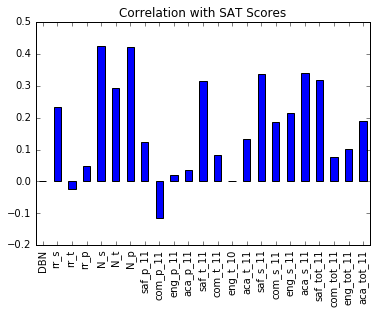

In [11]:
correlations[survey_fields].plot.bar(title = 'Correlation with SAT Scores')
plt.ylabel('R Values')
plt.show()

Suprisingly, the number of student responders (N_s) and number of partent responders (N_p) appear to be the most correlated to SAT scores.  Academic expectation score based on student repondents (aca_s_11) had a correlation that could be meaningful whereas academic expectation score based on parent (aca_p_11) and teacher (aca_t_11) respondents were barely correlated to SAT scores. Safety and Respect score based on student (saf_s_11) and teacher (saf_t_11) respondents as well as total Safety and Respect score.

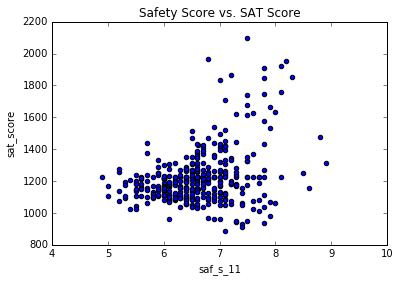

In [13]:
import matplotlib.pyplot as plt
combined.plot.scatter('saf_s_11', 'sat_score')
plt.title('Safety Score vs. SAT Score')
plt.show()

Judging from the plot above, it appears that safety and respect score based on student respondents is not well correlated with SAT scores when the SAT scores are on the lower end.  

## Mapping Safety Score

In [14]:
Dgroup = combined.groupby('school_dist').agg(np.mean)
Dgroup.reset_index(inplace = True)

In [15]:
from mpl_toolkits.basemap import Basemap

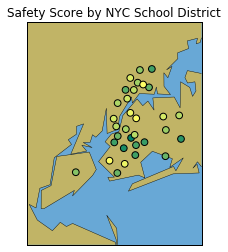

In [16]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.4, 
    urcrnrlat=41, 
    llcrnrlon=-74.3, 
    urcrnrlon=-73.68,
    resolution='i'
)

m.drawmapboundary(fill_color='#68a8d6')
m.drawcoastlines(linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color = '#c1b466')

longit = Dgroup['lon'].tolist()
latit = Dgroup['lat'].tolist()

m.scatter(longit, latit, s = 45, zorder = 2, latlon = True, c = Dgroup['saf_s_11'], cmap = 'summer')
plt.title('Safety Score by NYC School District')
plt.show()


NYC has five boroughs as can be found at [https://www.nycgo.com/boroughs-neighborhoods].  The map above indicates that Brooklyn has both some of the safest and most dangerous school districts.  

## Exploring Scores by Race

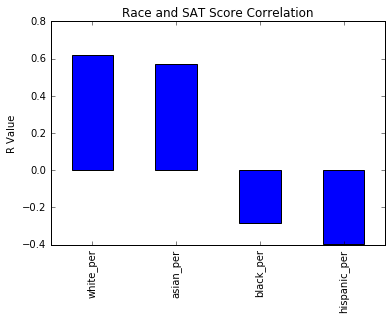

In [23]:
correlations[['white_per', 'asian_per', 'black_per', 'hispanic_per']].plot.bar(title = 'Race and SAT Score Correlation')
plt.ylabel('R Value')
plt.show()

It appears that schools with a higher percentage of white or Asian students tend to have higher SAT scores, whereas those with higher percentage of black or Hispanic students, especially Hispanic, tend to have lower scores.

In [24]:
#getting a list of schools with 'hispanic_per' greater than 95%
combined.loc[combined['hispanic_per']> 95,'SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

A lot of the schools with a percentage of hispanic students are geared towards recent immigrant or Spanish-speaking students.  If many of the students recently immigrated, the barrier of having to learn English might play a factor in their SAT scores.  

In [25]:
#schools with low hispanic percentageand high SAT scores
combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools that have lower than 10 percent of hispanic students and average SAT scores above 1800, tend to be specialized in STEM topics with some extra entrance requirements.

## Exploring Scores by Gender

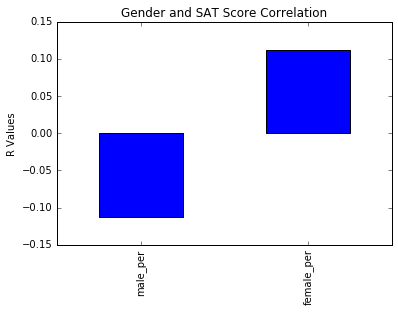

In [26]:
correlations[['male_per', 'female_per']].plot.bar(title = 'Gender and SAT Score Correlation')
plt.ylabel('R Values')
plt.show()

The bar chart shows that a higher female percentage (and therefore lower male percentage) has a very weak positive correlation with SAT score.

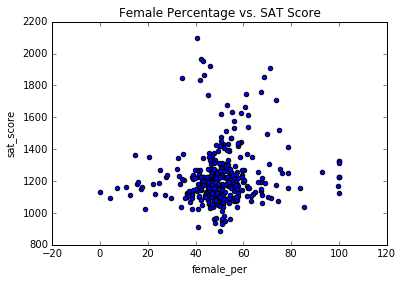

In [27]:
combined.plot.scatter('female_per', 'sat_score')
plt.title('Female Percentage vs. SAT Score')
plt.show()

The plot above shows that the schools with the highest SAT scores tends to be in the mid-range (40-70%) in terms of percentage of females.  

In [31]:
#finding schools with high percentage of females and SAT scores
combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['SCHOOL NAME']


5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools that are over 60 percent females and have SAT scores above 1700 appear to be schools that accept students with higher levels of acadmeic accomplishments.  

## Percent of AP Test Takers and SAT Scores

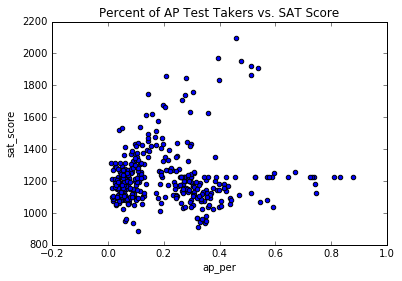

In [32]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
combined.plot.scatter('ap_per', 'sat_score')
plt.title('Percent of AP Test Takers vs. SAT Score')
plt.show()

It appears that percent of AP test takers has a stronger positive correlation when only SAT scores above about 1400 are taken into account in comparison to the the full range of SAT scores. 

*Note:  The code up to the 'Finding Correlations' section has mainly Dataquest code but is based on excercises I had completed previously*